In [ ]:
!pip install yfinance matplotlib numpy pandas

In [ ]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Past_data_years=7


def get_historical_data(ticker, end_date, lookback_years=Past_data_years):
    """
    Λαμβάνει ιστορικά δεδομένα από Yahoo Finance.
    """
    start_date = pd.to_datetime(end_date) - pd.DateOffset(years=lookback_years)
    df = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date, auto_adjust=False) # Added auto_adjust=False
    return df


def calculate_volatility(df, period='daily'):
    """
    Υπολογίζει το historical volatility από ιστορικά δεδομένα.
    """
    if period == 'daily':
        df['Returns'] = df['Close'].pct_change()
        volatility = df['Returns'].std() * math.sqrt(252)  # Annualized daily volatility
    elif period == 'monthly':
        df_monthly = df['Close'].resample('M').last().pct_change()
        volatility = df_monthly.std() * math.sqrt(12)  # Annualized monthly volatility
    else:
        raise ValueError("Unsupported period. Use 'daily' or 'monthly'.")
    return volatility


def binomial_model(
    payoff_func,
    S0=None,
    ticker=None,
    end_date=None,
    K=None,
    T=1,
    r=0.05,
    sigma=None,
    N=100,
    american=True,
    plot_tree=False
):
    """
    Γενικευμένο διωνυμικό μοντέλο.

    Parameters:
    - payoff_func: Συνάρτηση payoff (St -> float)
    - S0: Αρχική τιμή asset (αν δεν δοθεί, χρησιμοποιεί ticker)
    - ticker: Το symbol της μετοχής (π.χ. "AAPL")
    - end_date: Ημερομηνία για λήψη τιμής (π.χ. "2024-12-31")
    - K: Strike price (αν χρειάζεται στην payoff)
    - T: Χρόνος λήξης (σε έτη)
    - r: Επιτόκιο χωρίς κίνδυνο
    - sigma: Volatility (αν δεν δοθεί, υπολογίζεται από ιστορικά)
    - N: Αριθμός βημάτων
    - american: Αν είναι αμερικανική δικαιοληψία
    - plot_tree: Αν θα σχεδιαστεί το δέντρο
    """

    # Πάρε την τιμή από ticker αν δεν δοθεί S0
    if S0 is None and ticker:
        df_hist = get_historical_data(ticker, end_date)
        S0 = df_hist['Adj Close'].iloc[-1]
        if sigma is None:
            sigma = calculate_volatility(df_hist)

    elif S0 is None:
        raise ValueError("Πρέπει να δοθεί S0 ή ticker.")

    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    p = (math.exp(r * dt) - d) / (u - d)

    # Δημιουργία δέντρου asset
    stock_tree = [[S0 * (d ** j) * (u ** (i - j)) for j in range(i + 1)] for i in range(N + 1)]

    # Δημιουργία δέντρου αξίας δικαιοληψίας
    option_tree = [[0.0 for _ in range(i + 1)] for i in range(N + 1)]

    # Υπολογισμός payoff στη λήξη
    for j in range(N + 1):
        St = stock_tree[N][j]
        option_tree[N][j] = payoff_func(St, K=K)

    # Υπολογισμός πίσω
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold_value = math.exp(-r * dt) * (p * option_tree[i + 1][j + 1] + (1 - p) * option_tree[i + 1][j])
            if american:
                exercise_value = payoff_func(stock_tree[i][j], K=K)
                option_tree[i][j] = max(hold_value, exercise_value)
            else:
                option_tree[i][j] = hold_value

    price = option_tree[0][0]

    # --- Σχεδίαση ---
    if plot_tree:
        fig, ax = plt.subplots(figsize=(12, 6))
        for i in range(N + 1):
            for j in range(i + 1):
                x = i
                y = i - 2 * j
                label = f"{option_tree[i][j]:.2f}"
                ax.text(x, y, label, ha='center', va='center', fontsize=9,
                        bbox=dict(facecolor='lightgreen', alpha=0.7))

                if i < N:
                    ax.plot([x, x + 1], [y, y + 1], 'k-', lw=0.5)
                    ax.plot([x, x + 1], [y, y - 1], 'k-', lw=0.5)

        ax.set_title(f"Δέντρο Αξίας Δικαιώματος ({ticker})")
        ax.axis('off')
        plt.tight_layout()
        plt.show()

    return price

[*********************100%***********************]  1 of 1 completed


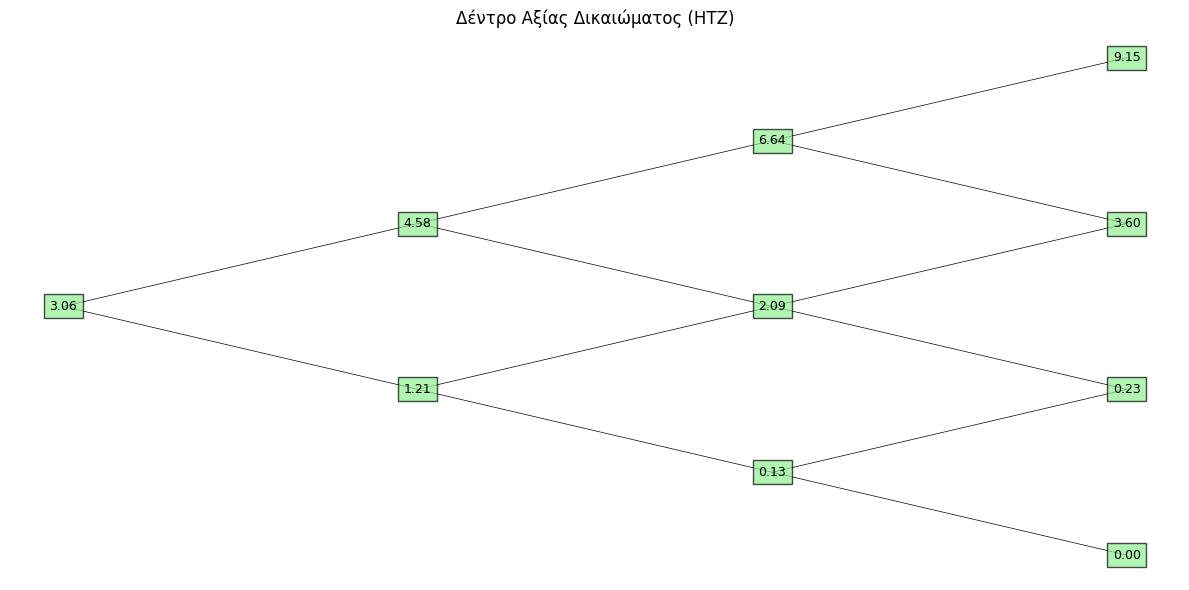

Option Price: 3.0586


In [ ]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime





# --- Παράδειγμα συνάρτησης payoff  --- Μπορείτε να την αλλάξετε σε οποιαδήποτε συνάρτηση θέλετε
def call_payoff(St, K):
    if isinstance(St, pd.Series):
        St = St.item()
    return np.maximum(np.maximum(St-5,0),np.maximum(3-St,0))

price = binomial_model(
    payoff_func=call_payoff,
    ticker="HTZ", # Εταιρεία
    end_date="2025-05-20",  # Για να υπολογίσει τη μεταβλητότητα με ιστορικά δεδομένα. Στο προηγούμενο κελί έχουμε εισάγει το πλήθος παρελθοντικών ετών
    K=5.2,  # Δεν χρειάζεται αν είναι ήδη στη συνάρτηση απολαβής παραπάνω
    T=0.3,   # Πότε λήγει το συμβόλαιο
    r=0.045, # Επιτόκιο
    N=3, # Το πλήθος των υπο-περιόδων.
    american=False, # Αν είναι Αμερικανικού τύπου βάλτε True αλλιώς False
    plot_tree=True # Αν είναι True θα σχεδιάσει και το δέντρο
)
print(f"Option Price: {price:.4f}")